## Introduction to murmurations for elliptic curves
------------------------------------------------------------------------
In this Jupyter notebook, we will introduce murmurations and try to explain why they are so surprising.
For the original research paper introducing murmurations see the paper [HLOP].
For the workshop where I originally learned about murmurations see [Murmurations in Arithmetic].
The workshop website also has links to the talks given at the workshop, please check it out.

First, let's see an example of a murmuration as originally discovered by the authors of [HLOP].
For this, we have downloaded the list of elliptic curves with conductor in the range 1-10000 from [LMFDB].
You can see the query which was used for the LMFDB website to generate the file in each file.
For example, for [1-10000], we searched for curves with conductor less than 10000, choosing one curve to represent each isogeny class.
We then used a gp script [gp/pari] to compute the traces of Frobenius for primes $p\leq 10000$.
You can see the results of the gp script in the file [first example].
For more information on how the data files were generated, see [data].

[HLOP]: https://arxiv.org/abs/2204.10140
[Murmurations in Arithmetic]: https://icerm.brown.edu/events/htw-23-ma/
[1-10000]: data/ec_curve_data_10000.gp
[LMFDB]: https://www.lmfdb.org/EllipticCurve/Q/
[gp/pari]: https://pari.math.u-bordeaux.fr/
[first example]: data/first-example.data
[data]: DATA.md

In [0]:
## if running from google colab uncomment:
## !pip install -q ipympl
## from google.colab import output
## output.enable_custom_widget_manager()

In [5]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
%matplotlib widget

In [10]:
## if running locally uncomment
from pyscript.murmur_from_dataframe import display_murmuration

## if running from google colab uncomment:
''' 
def display_murmuration(ec,scale,primes,title,ax,xlim=None,ylim=None):
  for axis in ax:
    axis.clear();
    if xlim:
      axis.set_xlim(xlim)
    if ylim:
      axis.set_ylim(ylim)
  t = primes.astype(int)*scale;
  ax[0].plot(t,ec.loc[ec['rank']==1,primes].mean(),'b.');
  ax[1].plot(t,ec.loc[ec['rank']==-1,primes].mean(),'r.');
  ax[2].plot(t,ec[primes].mul(ec['rank'],axis=0).mean(),'c.');
  ax[0].set_title(title+", even rank");
  ax[1].set_title(title+", odd rank");
  ax[2].set_title(title+", combined ranks");

def display_rescaled_murmuration(x,sum_aps_even,counts_even,sum_aps_odd,counts_odd,title,ax,xlim=None,ylim=None):
  for axis in ax:
    axis.clear();
    if xlim:
      axis.set_xlim(*xlim)
    if ylim:
      axis.set_ylim(*ylim)
  ax[0].plot(x,sum_aps_even/counts_even,'b.');
  ax[1].plot(x,sum_aps_odd/counts_odd,'r.');
  ax[2].plot(x,(sum_aps_even-sum_aps_odd)/(counts_even+counts_odd),'c.');
  ax[0].set_title(title+", even");
  ax[1].set_title(title+", odd");
  ax[2].set_title(title+", combined ranks");
```

In [19]:
local = "data/"
file = "first_example.data"

## if running from google colaboratory uncomment:
## web_path = "https://cocalc.com/share/raw/0448bd6dd0e1a069e5104218be9425b1d08ad4ac/data-science/elliptic-curves/"
## !curl --create-dirs -O --output-dir $local $web_path$local$file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  408M    0 96696    0     0   396k      0  0:17:33 --:--:--  0:17:33  396k

 33  408M   33  135M    0     0  25.9M      0  0:00:15  0:00:05  0:00:10 25.9M

 34  408M   34  141M    0     0  27.0M      0  0:00:15  0:00:05  0:00:10 27.0M

 68  408M   68  279M    0     0  34.4M      0  0:00:11  0:00:08  0:00:03 34.4M

 76  408M   76  311M    0     0  37.7M      0  0:00:10  0:00:08  0:00:02 37.7M

100  408M  100  408M    0     0  47.0M      0  0:00:08  0:00:08 --:--:-- 48.4M


In [20]:
datatype ={'label':np.dtype('str'),'discriminant':np.dtype('O')}
datatype.setdefault(np.dtype('int64'))
ec = pd.read_csv(local+file,
                 delimiter=" ",
                 index_col = 'label',
                 usecols=lambda x: x!='discriminant',
                 dtype = datatype
                )

We start by loading the data "first_example.data". This corresponds to the elliptic curves defined over $\mathbb{Q}$ having conductor in the range $7500$ to $10000$.
For each prime $p$ less than $100000$, we have computed $a_p(E)$ for each elliptic curve $E$ in our list.
We have the relation that $a_p(E) = N_p(E) -(p+1)$ where $N_p(E)$ is the number of points of the reduction of $E$ modulo $p$ (for most primes $p$).
Let's store a copy of the primes in our list.

In [4]:
primes = ec.columns[2:];

Each elliptic curve has a rank. Let's split up our data according to whether the rank is even or odd.
We'll put -1 for odd and 1 for even.

In [5]:
ec.loc[ec['rank']%2 ==1,'rank'] = -1;
ec.loc[ec['rank']%2==0,'rank'] = 1;
ec.head()

,conductor,rank,2,3,5,7,11,13,17,19,...,99877,99881,99901,99907,99923,99929,99961,99971,99989,99991
label,,,,,,,,,,,,,,,,,,,,,
7501.a1,7501,1,1,2,-2,4,3,1,7,-5,...,-150,81,-528,54,12,-394,127,-182,-522,-290
7502.a1,7502,-1,-1,-2,0,1,0,4,3,-2,...,-302,342,70,476,468,-87,-298,54,-285,-358
7502.a2,7502,-1,-1,-2,0,1,0,4,3,-2,...,-302,342,70,476,468,-87,-298,54,-285,-358
7502.a3,7502,-1,-1,-2,0,1,0,4,3,-2,...,-302,342,70,476,468,-87,-298,54,-285,-358
7502.b1,7502,1,-1,0,-2,0,0,-2,6,-4,...,118,-302,-222,236,420,-390,-558,320,-534,-592


Let's display our first murmurations. We will look at primes $p$ less than $20000$, and for each $p$, we will compute the average of $a_p(E)$ over elliptic curves $E$ in our list.
Recall that $a_p(E)$ satisfies the following bound: $|a_p(E)|\leq 2\sqrt{p}$.
One of the motivations to study these $a_p$'s is the conjecture of [Birch and Swinnerton-Dyer](https://en.wikipedia.org/wiki/Birch_and_Swinnerton-Dyer_conjecture).

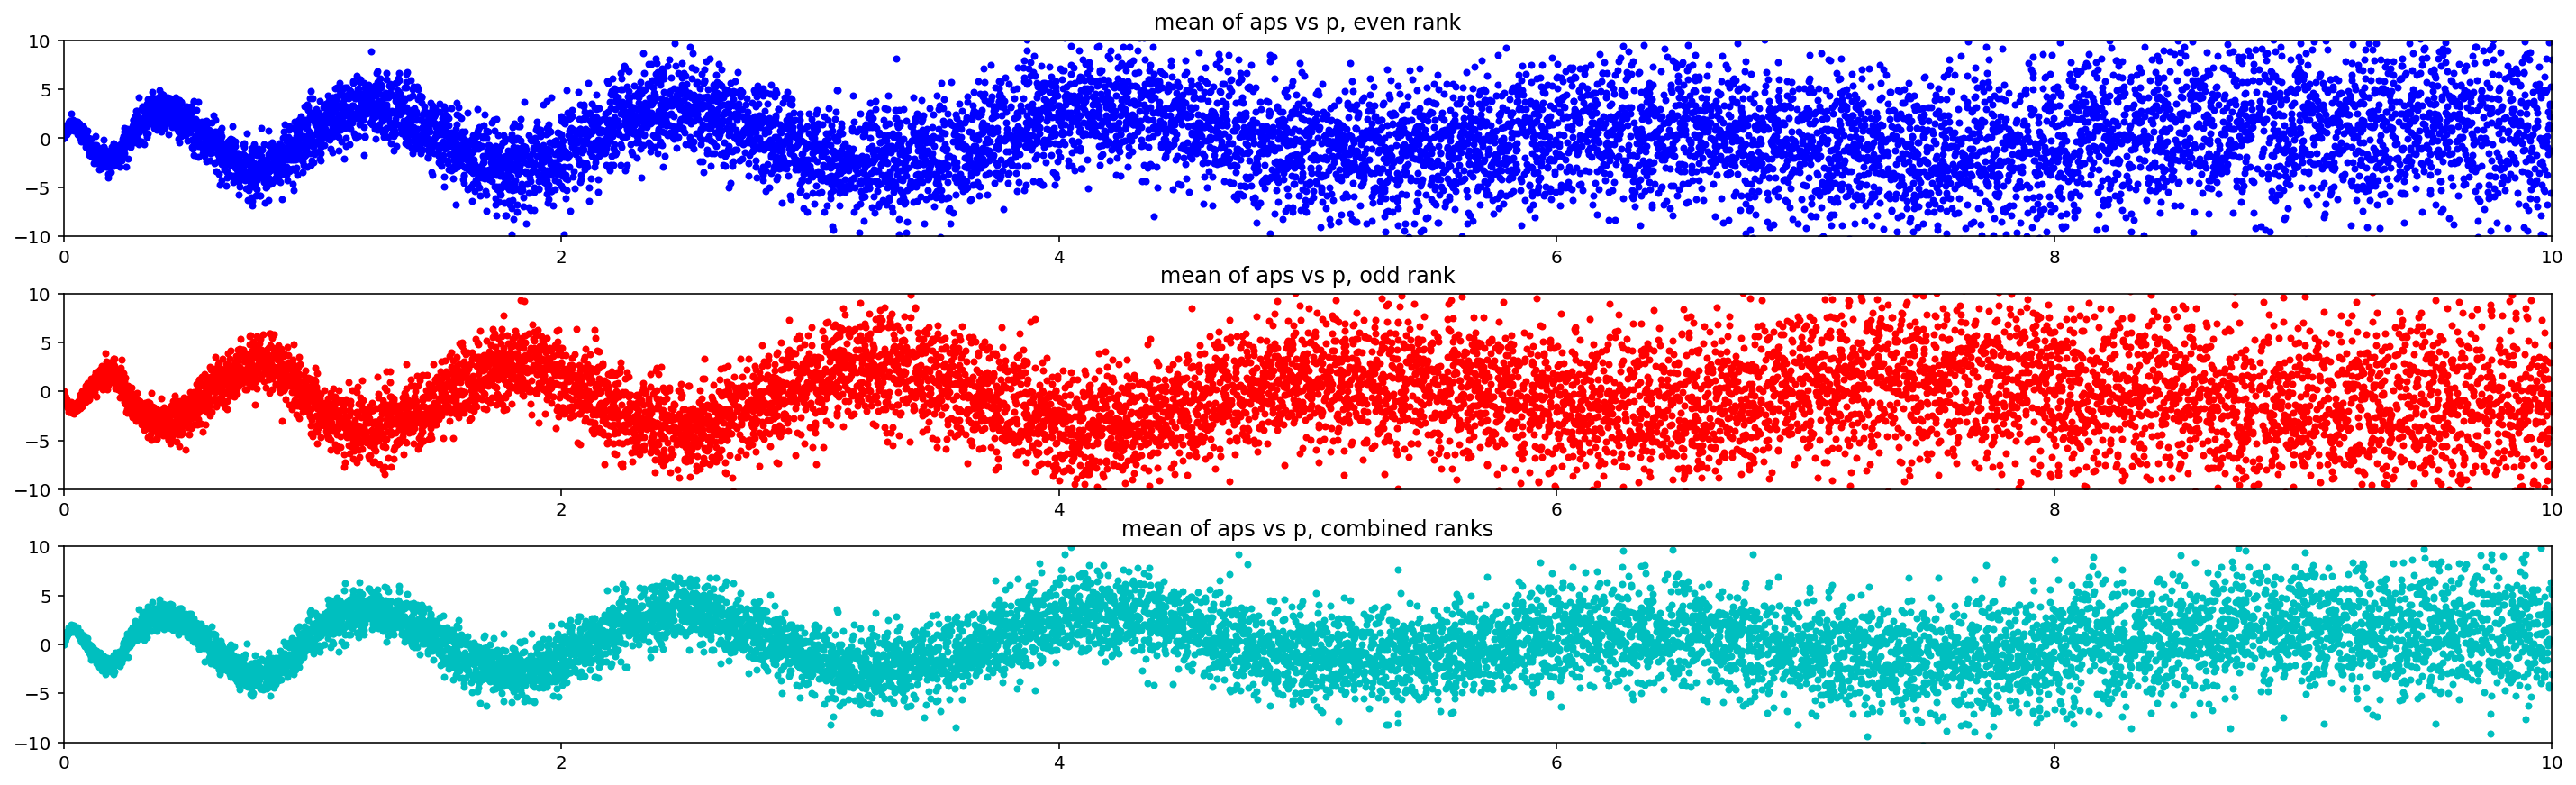

In [6]:
fig, ax = subplots(3,figsize=(20,6));
fig.tight_layout()
for axis in ax:
    axis.set_ylim(-10,10);
    axis.set_xlim(0,10)
scale=1.0/10000;
display_murmuration(ec,scale,primes,"mean of aps vs p",ax)
## fig.savefig("media/plot_cond_7500_10000.png")

It is hard to overstate how surprising these plots are.
To give you an idea of scale, at $x=2$ on the plots, we are taking the average of $a_p(E)$ for $p\sim 20000$, and we are taking the average of about 16000 curves.
Here is the same plot when we do not separate the even rank from the odd rank.

Text(0.5, 1.0, 'average aps vs p, not controlled for rank')

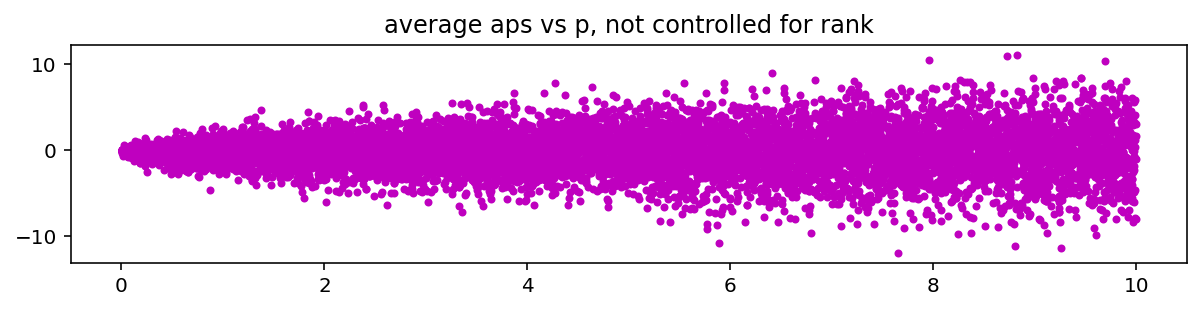

In [7]:
fig2,ax2 = subplots(figsize=(10,2));
ax2.plot(primes.astype(int)*scale,ec[primes].mean(),'m.')
ax2.set_title("average aps vs p, not controlled for rank")

Let's see if we can tell what the shape of our 'murmuration' is by using a polynomial fit.

Text(0.5, 1.0, 'Average aps vs p and a polynomial approximation of degree 30')

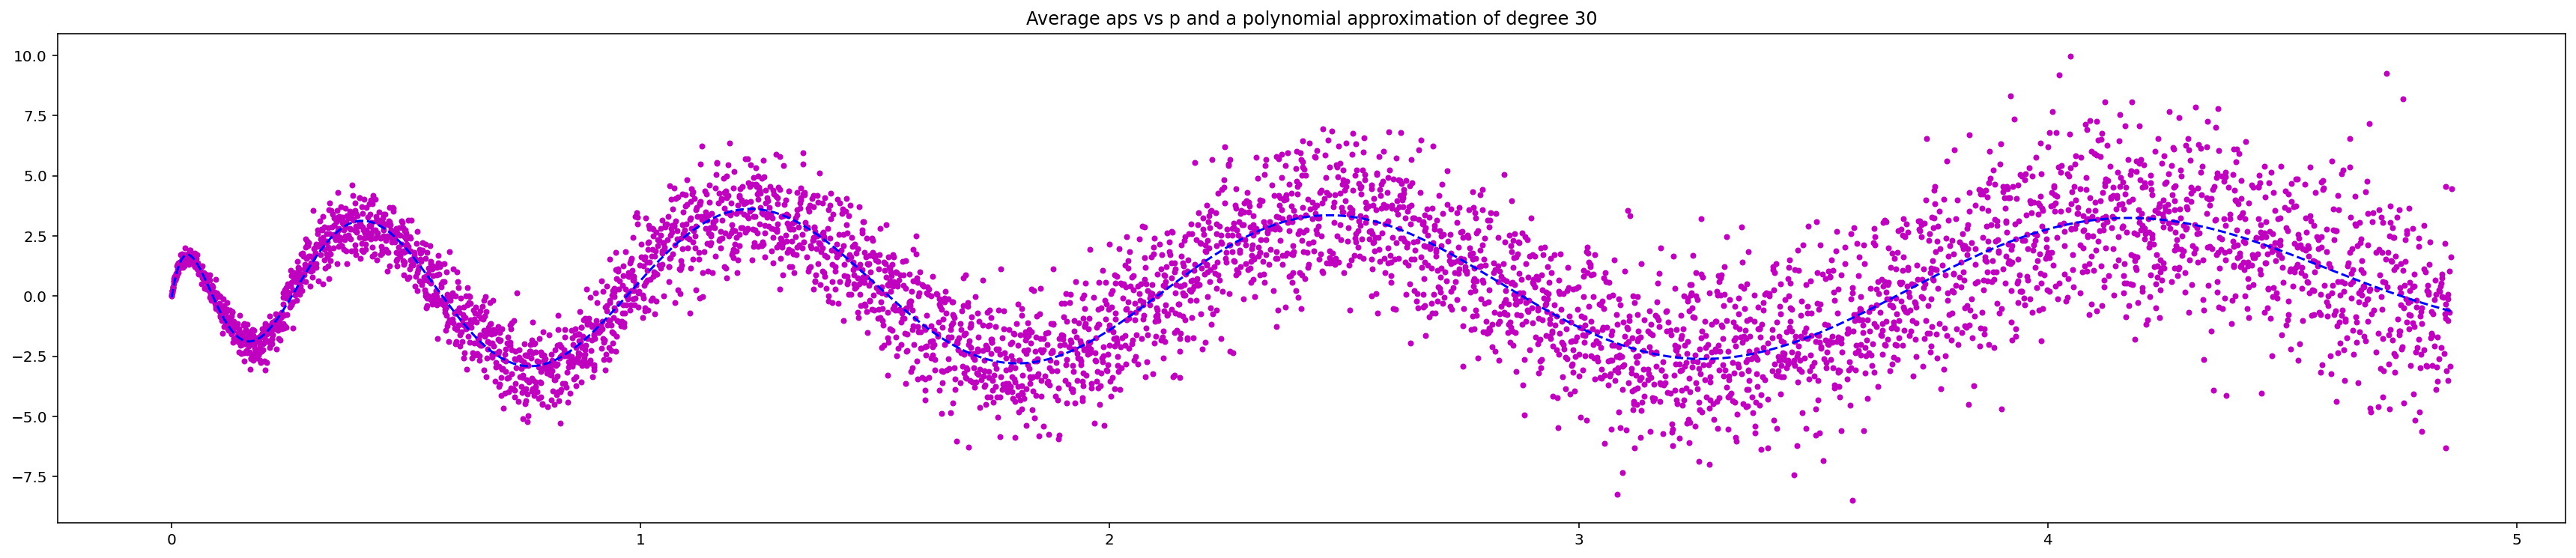

In [8]:
from numpy.polynomial import Polynomial as P
t = primes.astype(int)*scale;
polyfit = P.fit(t,ec[primes].mul(ec['rank'],axis=0).mean(),30)
fig3, ax3 = subplots(figsize=(30,6));
ax3.plot(t[:5000],ec[primes[:5000]].mul(ec['rank'],axis=0).mean(),'.m',t[:5000],polyfit(t[:5000]),'b--');
ax3.set_title("Average aps vs p and a polynomial approximation of degree 30")

The plot looks almost periodic. Also, as $p$ gets larger there seems to be more and more noise.

Text(0.5, 1.0, 'Randomly chosen row with odd rank')

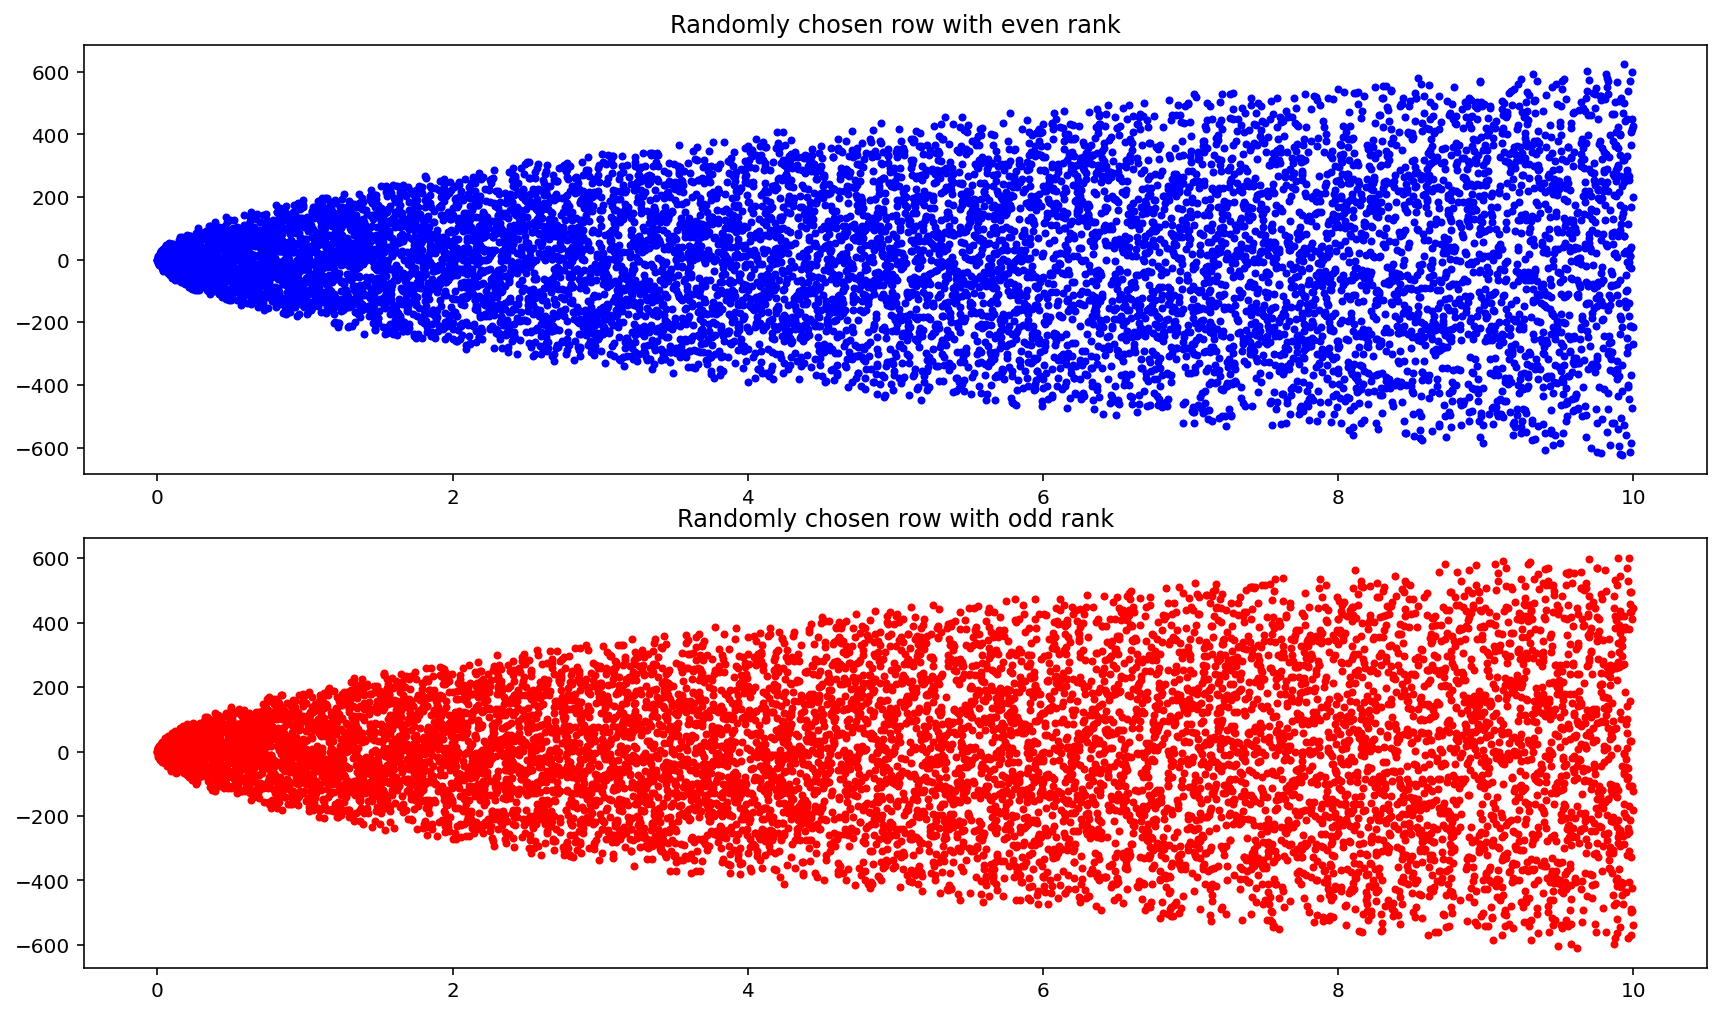

In [13]:
fig4,ax4 = subplots(2);
fig4.tight_layout();
ax4[0].plot(t,ec.loc[ec['rank']==1,primes].sample(1).transpose(),'b.');
ax4[0].set_title("Randomly chosen row with even rank")
ax4[1].plot(t,ec.loc[ec['rank']==-1,primes].sample(1).transpose(),'r.');
ax4[1].set_title("Randomly chosen row with odd rank")

Text(0.5, 1.0, 'Error of polynomial fit vs p')

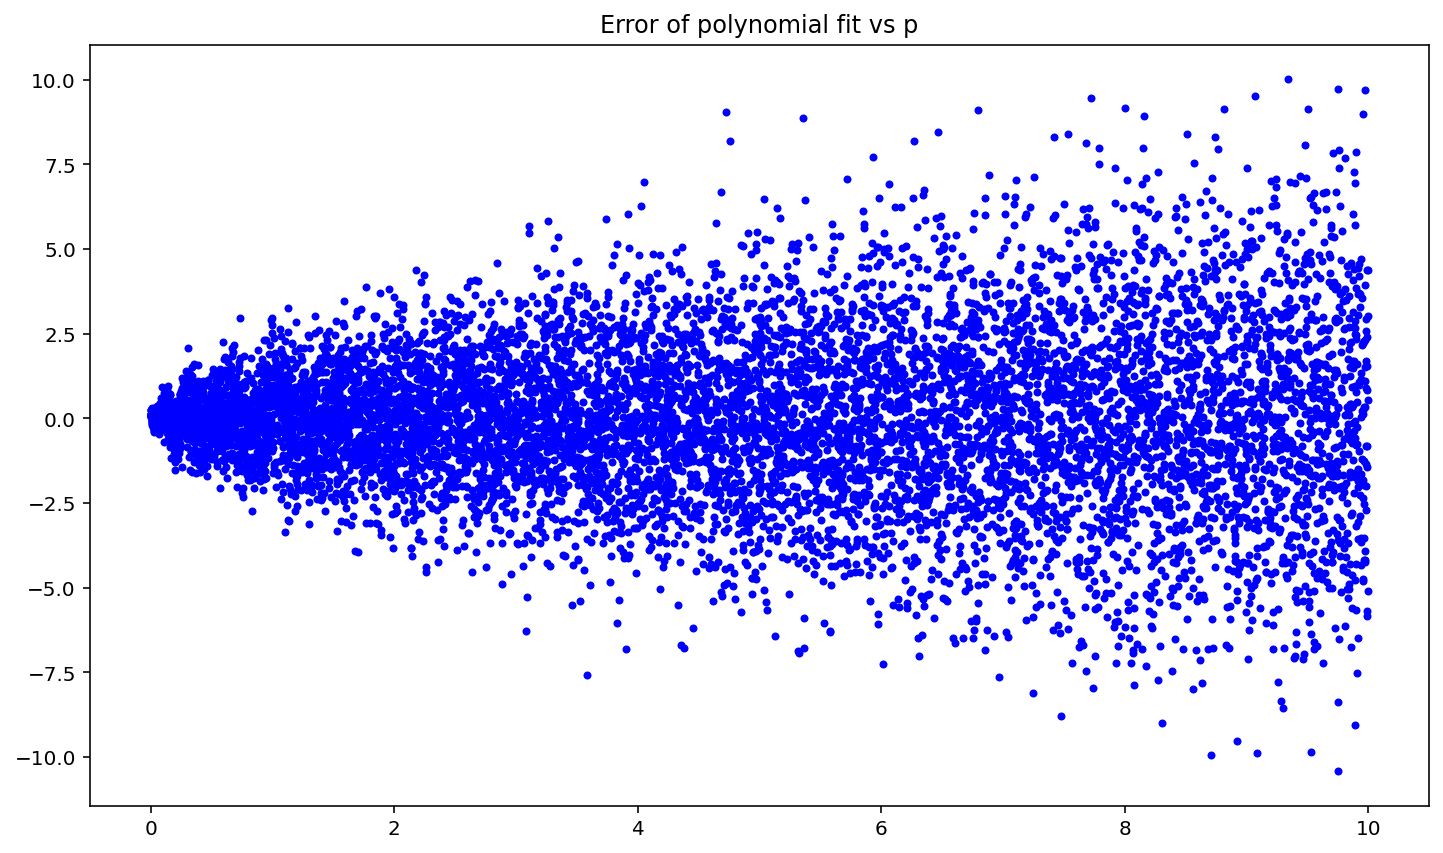

In [14]:
ERR = ec[primes].mul(ec['rank'],axis=0).mean()-polyfit(t);
fig5, ax5 = subplots();
ax5.plot(t,ERR,'b.')
ax5.set_title("Error of polynomial fit vs p/10000")

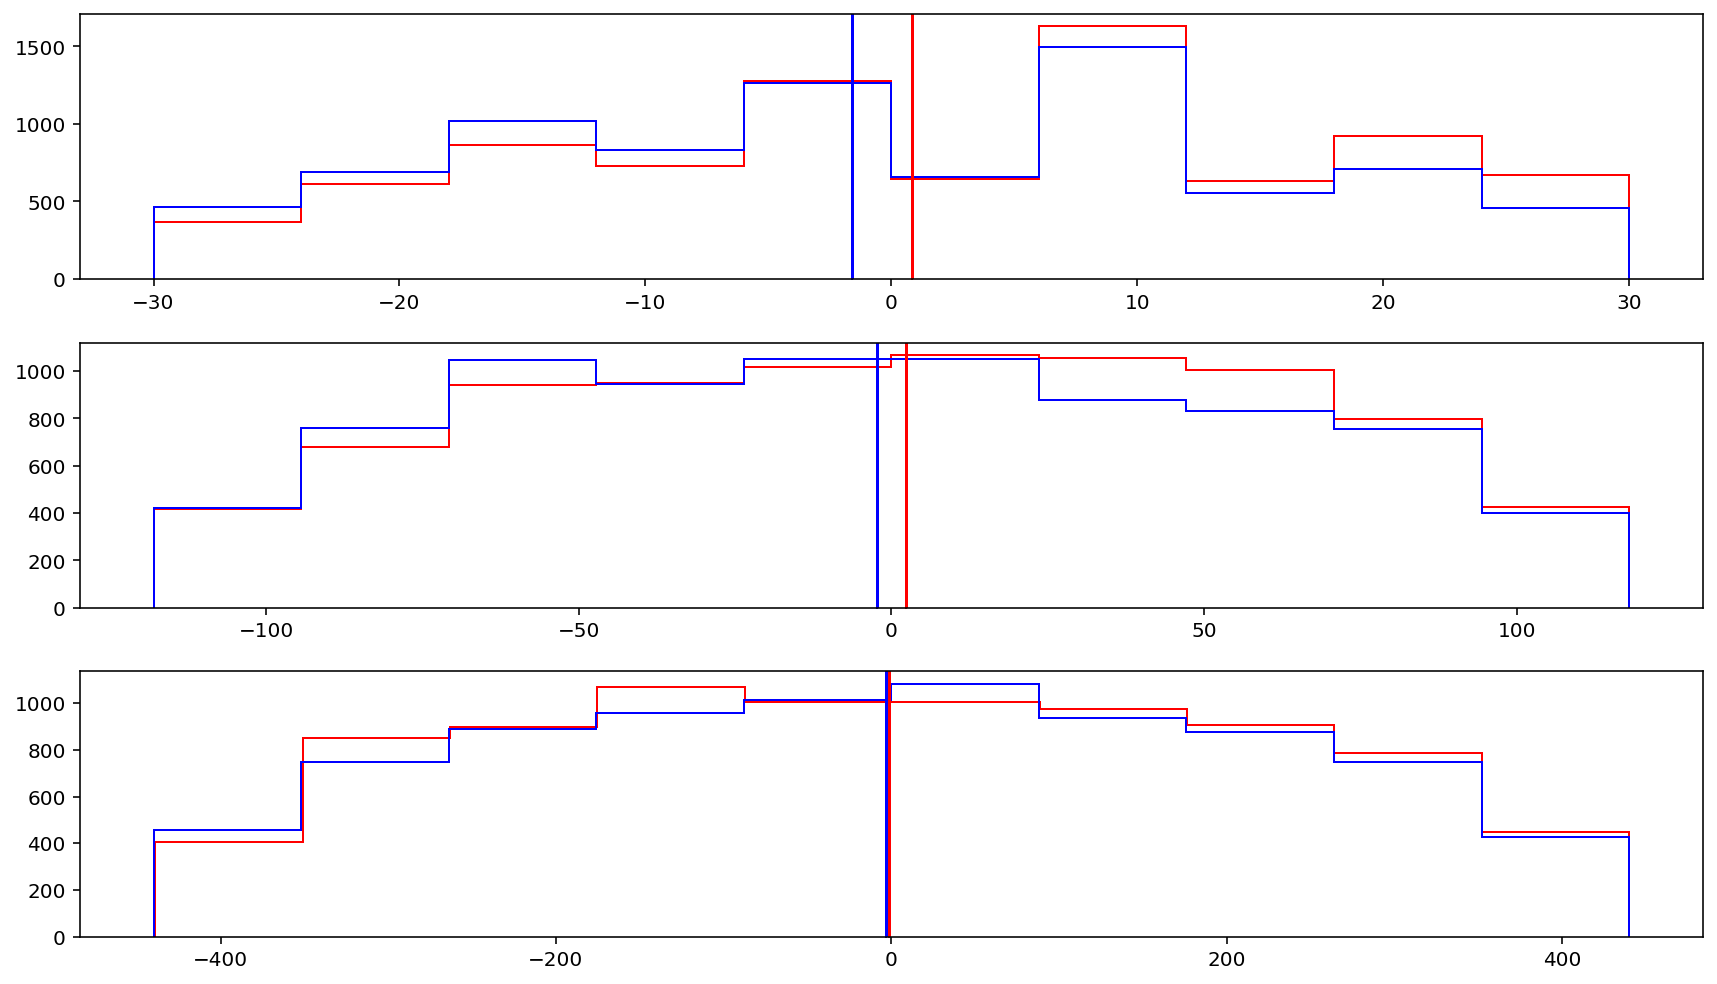

In [15]:
fig6, ax6 = subplots(3);
fig6.tight_layout()
ax6[0].hist(ec.loc[ec['rank']==1][primes[50]],color='red',histtype='step');
ax6[0].hist(ec.loc[ec['rank']==-1][primes[50]],color='blue',histtype='step')
ax6[0].axvline(ec.loc[ec['rank']==1][primes[50]].mean(),marker='|',color='red')
ax6[0].axvline(ec.loc[ec['rank']==-1][primes[50]].mean(),marker='|',color='blue')
ax6[1].hist(ec.loc[ec['rank']==1][primes[500]],color='red',histtype='step');
ax6[1].hist(ec.loc[ec['rank']==-1][primes[500]],color='blue',histtype='step')
ax6[1].axvline(ec.loc[ec['rank']==1][primes[500]].mean(),marker='|',color='red')
ax6[1].axvline(ec.loc[ec['rank']==-1][primes[500]].mean(),marker='|',color='blue')
ax6[2].hist(ec.loc[ec['rank']==1][primes[5000]],color='red',histtype='step');
ax6[2].hist(ec.loc[ec['rank']==-1][primes[5000]],color='blue',histtype='step')
ax6[2].axvline(ec.loc[ec['rank']==1][primes[5000]].mean(),marker='|',color='red')
ax6[2].axvline(ec.loc[ec['rank']==-1][primes[5000]].mean(),marker='|',color='blue')

Above we can see that there is very slight biases between the $a_p(E)$ between when the rank is even and the rank is odd.

In [0]:
cond_200k = "cond_200k_1.data"

## if running from google colaboratory uncomment:
## !curl --create-dirs -O --output-dir $local $web_path$local$cond_200k

In [16]:
ec_100k = pd.read_csv(local+cond_200k,
                      delimiter=" ",
                      index_col = 'label',
                      usecols=lambda x:x!='discriminant',
                      dtype = datatype
                     )

Let's now examine a dataset containing 5673 elliptic curves of conductors ranging from 100002 to 100800 obtained from the LMFDB.
I computed the $a_p(E)$ for $p\leq 200000$.

In [17]:
ec_100k['conductor'].describe()

count      5672.000000
mean     100459.058533
std         250.202793
min      100002.000000
25%      100254.000000
50%      100464.000000
75%      100680.000000
max      100800.000000
Name: conductor, dtype: float64

In [18]:
primes_200k = ec_100k.columns[2:];
ec_100k.loc[ec_100k['rank']%2==1,'rank']=-1;
ec_100k.loc[ec_100k['rank']%2==0,'rank']=1;

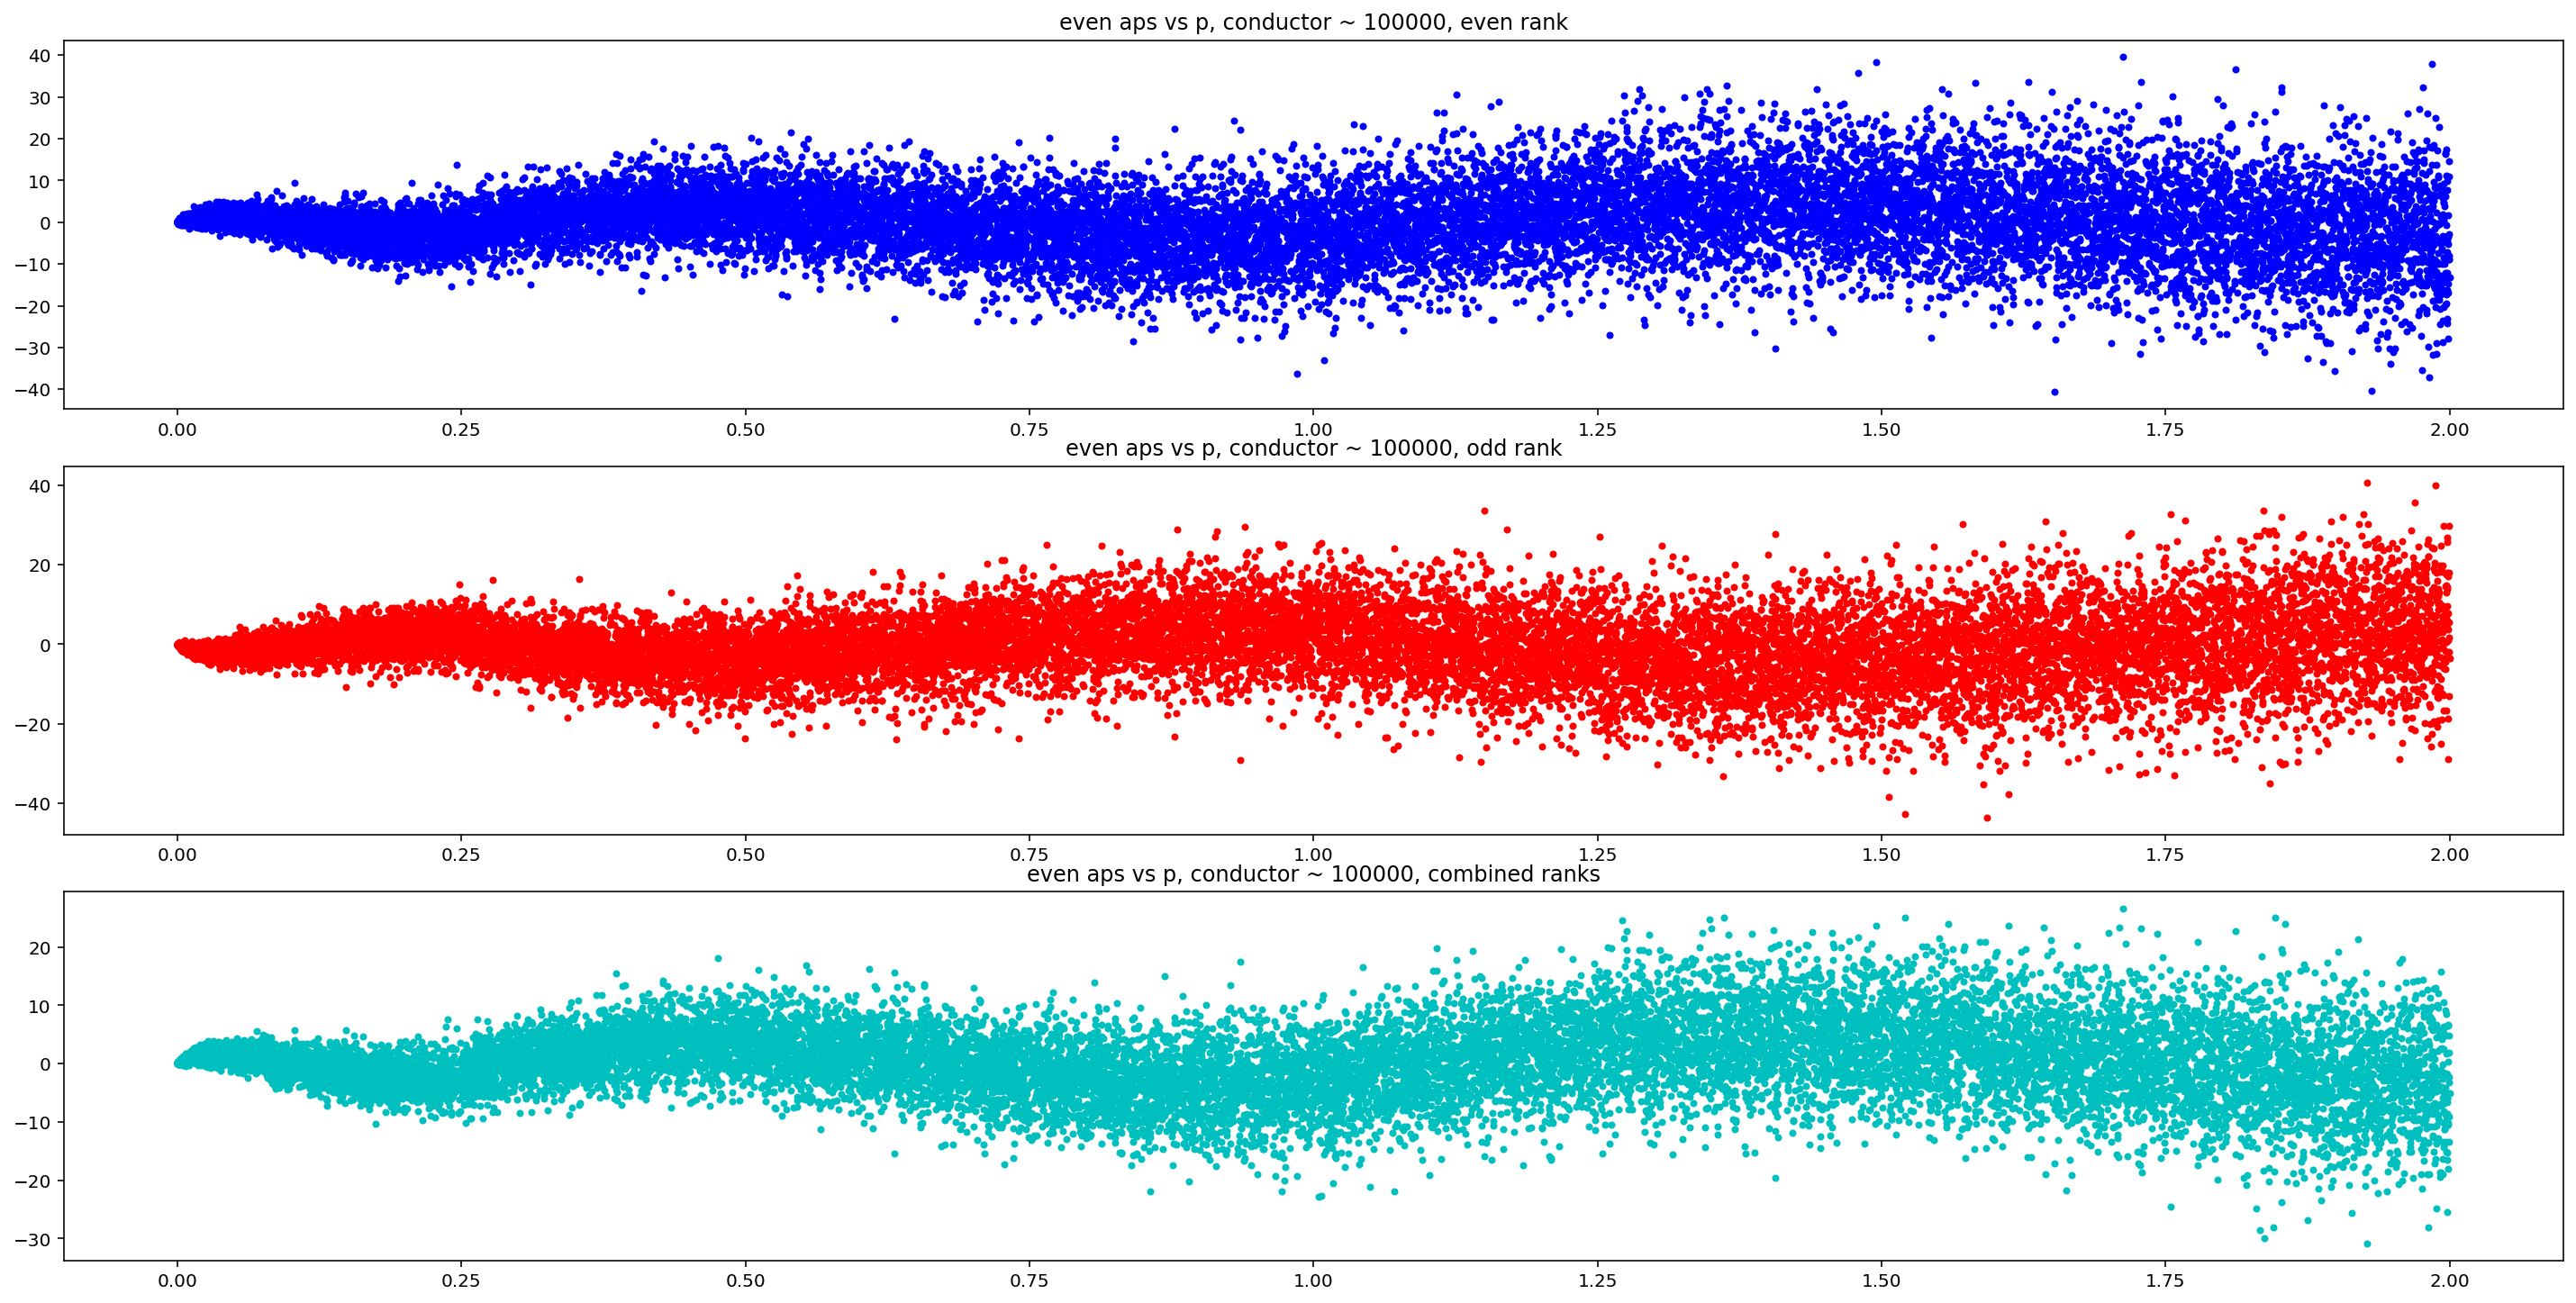

In [19]:
scale = 1.0/100000;
fig7, ax7 = subplots(3,figsize=(20,10));
fig7.tight_layout()
display_murmuration(ec_100k,scale,primes_200k,"even aps vs p, conductor ~ 100000",ax7)

Even though there is a small range of conductors, we still see the murmuration behaviour.
Not only that, but we see a similar curve but on a different scale.
Below we compare the data for curves with conductor approximately 100000 to the previously computed polynomial fit for curves with conductor from 7500 to 10000.
The thing to note is that the scale for the original fit was $10^{-4}$ and below the scale is $10^{-5}$.

Text(0.5, 1.0, 'Average aps vs p, normalized by parity of rank, Conductor~100000, p <= 200000')

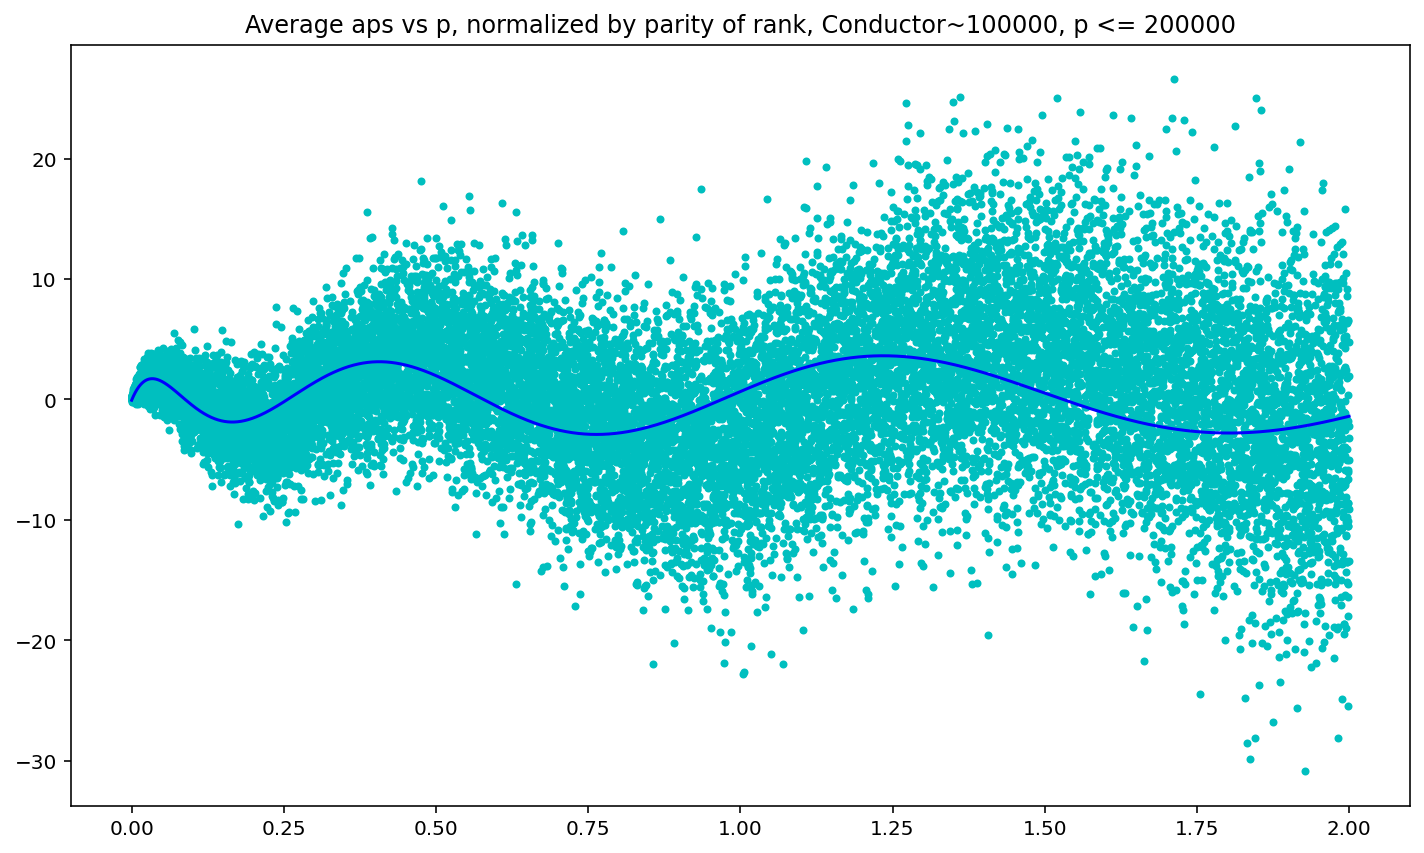

In [20]:
fig8, ax8 = subplots(figsize=(10,3));
t_200k = primes_200k.astype(int)*scale;
ax8.plot(t_200k,ec_100k[primes_200k].mul(ec_100k['rank'],axis=0).mean(),'c.',\
         t_200k,polyfit(t_200k),'b-')
ax8.set_title("Average aps vs p, normalized by parity of rank, Conductor~100000, p <= 200000")

So we see that the mumuration occurs at scale according to the reciprocal of the conductor.
Our final dataset for this notebook is a list of curves containing curves from 1-50000. I have computed the $a_p(E)$ for $p\leq 50000$ in this dataset,
and saved it to 14 different files.
We will read in the datasets and display the graphs with scale according to the reciprocal of the mean of the conductor for each file.
I have then combined the 14 different plots into an animation.

In [21]:
files_50k = ["cond_50k_"+str(i)+".data" for i in range(1,15)];
## if using google colaboratory uncomment:
## for file in files_50k:
##   !curl --create-dirs -O --output-dir $local $web_path$local$file

In [21]:
sums_rank_0 = [None for _ in range(1,15)];
sums_rank_1 = [None for _ in range(1,15)];
counts_rank_0 = [0 for _ in range(1,15)];
counts_rank_1 = [0 for _ in range(1,15)];
mean_cond = [0 for _ in range(1,15)]
for i in range(14):
    ec_50k = pd.read_csv(local+files_50k[i],
                         delimiter=" ",
                         index_col = 'label',
                         usecols=lambda x: x!='discriminant',
                         dtype = datatype
                        )
    primes_50k = ec_50k.columns[2:]
    mean_cond[i] = ec_50k['conductor'].mean()
    sums_rank_0[i] = ec_50k.loc[ec_50k['rank']%2==0,primes_50k].sum()
    counts_rank_0[i] += len(ec_50k[ec_50k['rank']%2==0]);
    sums_rank_1[i] = ec_50k.loc[ec_50k['rank']%2 == 1,primes_50k].sum() 
    counts_rank_1[i] += len(ec_50k[ec_50k['rank']%2==1]);

NameError: name 'output_dir' is not defined

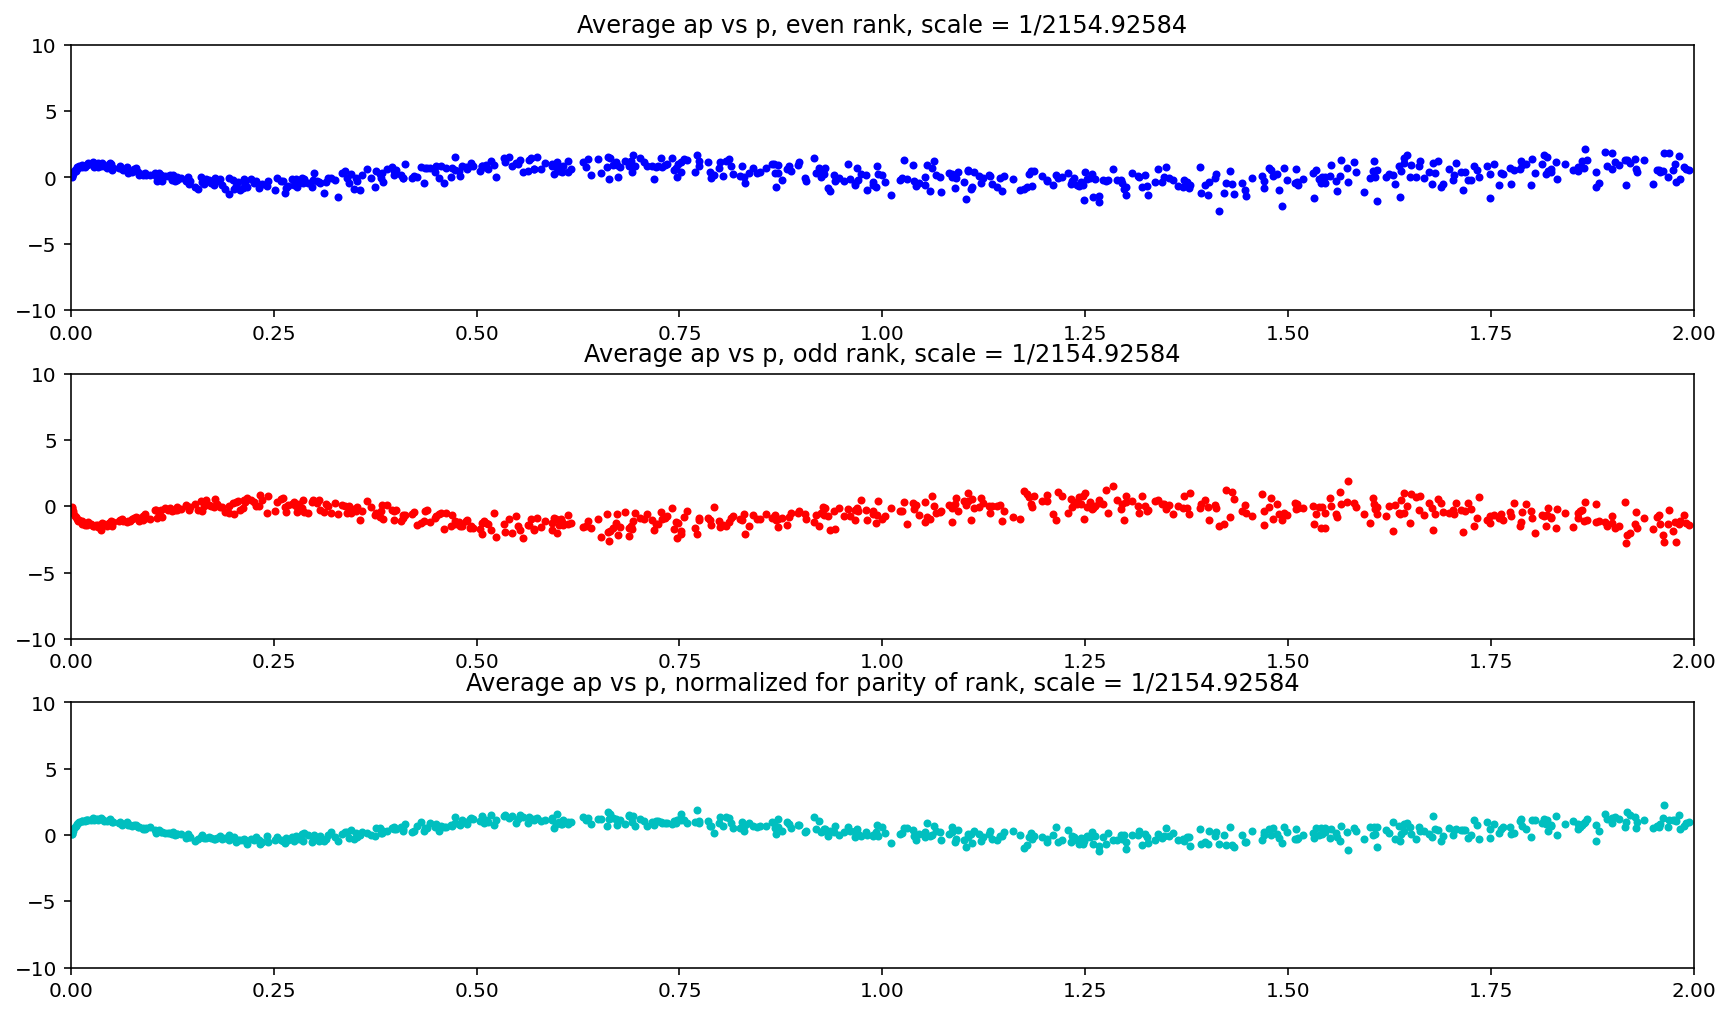

In [30]:
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
## uncomment if running locally
## from pyscript.murmur_from_dataframe import display_rescaled_murmuration
fig9, ax9 = subplots(3,figsize=(15,5));
fig9.tight_layout()
ylim=(-10,10)
xlim=(0,2)
title = "Average aps vs p, scale = 1/"
def update_plot(i):
    t = primes_50k.astype(int)/mean_cond[i];
    display_rescaled_murmuration(t,
                                 sums_rank_0[i],
                                 counts_rank_0[i],
                                 sums_rank_1[i],
                                 counts_rank_1[i],
                                 title +str(mean_cond[i]),
                                 ax9,
                                 xlim,
                                 ylim
                                 )
anim= animation.FuncAnimation(fig9,update_plot,14,interval=1000)

In [31]:
## anim.save("media/murmuration_animation.mp4")